# LifeSnaps NON Target Imputed Data Model
Aquest model de predicció agafa unicament els valors registrats tant en el TRAIN com en el TEST. Per tant no es fa imputacio de dades.

### Import de llibreries i warnings

In [34]:
# Exploració de dades
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessament de dades
from sklearn.preprocessing import StandardScaler,  OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Model
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Analisis del model
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay
)

In [35]:
import warnings
warnings.filterwarnings('ignore')

## Comprensió del Dataset

El dataset LifeSnaps captura dades multimodals recollides durant 4 mesos per 71 participants. Aquestes dades provenen del wearable, autoinformes (EMAs) i qüestionaris, i estan orientades a comprendre la relació entre hàbits de vida, salut física i mental, i comportaments.

Les dades venen del dispositiu Fitbit Sense, un dispositiu molt similar al Fitbit Inspire 3 (el disponible) però amb algunes funcions adicionals. Que s'hauràn de tenir en compte alhora de realitzar l'anàlisi exploratori de dades.


### Dimensions i estructura

Tal i com es veurà a continuació s'observa un dataset de 63 columnes i 7410 files, algunes d'elles sense contingut, s'hauran de tractar amb cura les dades i fer una bona neteja per obtenir els millor resultats possibles.

Es un dataset amb freqüencia de mostreig diària, es a dir les dades s'han recullit de forma diària. El LifeSnaps també te un dataset de horari, però crec que resulta més interessant el recull de dades diaries per les prediccions posteriors que es poden fer.

In [36]:
df = pd.read_csv('../../../03. Datasets/Lifesnaps Fitbit/csv_rais_anonymized/daily_fitbit_sema_df_unprocessed.csv')
pd.set_option('display.max_columns', None)

display(df.head(20))
df.info()


,Unnamed: 0,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,responsiveness_points_percentage,daily_temperature_variation,badgeType,calories,filteredDemographicVO2Max,distance,activityType,bpm,lightly_active_minutes,moderately_active_minutes,very_active_minutes,sedentary_minutes,mindfulness_session,scl_avg,resting_hr,sleep_duration,minutesToFallAsleep,minutesAsleep,minutesAwake,minutesAfterWakeup,sleep_efficiency,sleep_deep_ratio,sleep_wake_ratio,sleep_light_ratio,sleep_rem_ratio,steps,minutes_in_default_zone_1,minutes_below_default_zone_1,minutes_in_default_zone_2,minutes_in_default_zone_3,age,gender,bmi,step_goal,min_goal,max_goal,step_goal_label,ALERT,HAPPY,NEUTRAL,RESTED/RELAXED,SAD,TENSE/ANXIOUS,TIRED,ENTERTAINMENT,GYM,HOME,HOME_OFFICE,OTHER,OUTDOORS,TRANSIT,WORK/SCHOOL
0,0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,78.0,0.833333,0.675,0.866667,-1.788325,NaN,2351.59,62.79210,6517.5,['Walk'],71.701565,149.0,24.0,33.0,713.0,False,NaN,62.073070,31260000.0,0.0,445.0,76.0,0.0,93.0,1.243243,0.987013,0.921642,1.341772,8833.0,83.0,1349.0,0.0,0.0,<30,MALE,<19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,80.0,0.833333,0.725,0.866667,-2.462709,NaN,2332.08,62.67912,7178.6,['Walk'],70.579300,132.0,25.0,31.0,704.0,False,NaN,62.121476,32880000.0,0.0,460.0,88.0,0.0,94.0,1.466667,1.142857,0.947566,1.197531,9727.0,56.0,1374.0,4.0,0.0,<30,MALE,<19,14999,10000.0,15000.0,10000-14999,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,84.0,0.966667,0.725,0.866667,-2.385801,NaN,2262.30,62.57307,6090.9,['Walk'],71.842573,112.0,27.0,31.0,710.0,False,NaN,62.263999,33600000.0,0.0,493.0,67.0,0.0,96.0,1.116883,0.858974,1.015038,1.670732,8253.0,85.0,1350.0,0.0,0.0,<30,MALE,<19,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,82.0,0.933333,0.725,0.833333,-2.124199,['LIFETIME_DISTANCE'],2325.10,62.47493,6653.1,['Walk'],71.725477,133.0,21.0,37.0,622.0,False,NaN,62.368900,37620000.0,0.0,540.0,87.0,0.0,93.0,1.128205,1.129870,1.191729,1.588235,9015.0,90.0,1282.0,0.0,0.0,<30,MALE,<19,14999,10000.0,15000.0,10000-14999,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,81.0,0.866667,0.725,0.866667,-2.396873,NaN,2586.76,62.41166,9557.9,['Walk'],74.401028,136.0,42.0,54.0,647.0,False,NaN,61.965409,33660000.0,0.0,493.0,68.0,0.0,94.0,0.910256,0.871795,1.211896,1.090909,12949.0,146.0,1274.0,4.0,0.0,<30,MALE,<19,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,5,621e2e8e67b776a24055b564,2021-05-29,34.610929,57.314,89.941,NaN,14.8,82.0,0.900000,0.750,0.833333,-2.638646,"['DAILY_FLOORS', 'DAILY_STEPS', 'LIFETIME_FLOO...",3806.02,62.31740,18809.0,['Walk'],83.739770,305.0,128.0,98.0,371.0,False,NaN,62.671748,32280000.0,0.0,471.0,67.0,6.0,95.0,0.846154,0.870130,1.110294,1.170455,25526.0,428.0,986.0,2.0,0.0,<30,MALE,<19,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6,6,621e2e8e67b776a24055b564,2021-05-30,34.469155,61.900,92.763,NaN,15.2,81.0,0.833333,0.775,0.833333,-1.090828,NaN,1968.24,62.19706,2799.7,NaN,68.475259,113.0,9.0,0.0,763.0,False,NaN,63.359720,33300000.0,0.0,485.0,70.0,0.0,94.0,0.974026,0.909091,1.120438,1.157303,3796.0,20.0,1160.0,0.0,0.0,<30,MALE,<19,4999,2000.0,5000.0,2000-4999,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7,7,621e2e8e67b776a24055b564,2021-05-31,34.476865,58.652,109.509,NaN,14.8,84.0,0.933333,0.725,0.900000,-2.577960,NaN,2300.02,62.10474,6822.5,['Walk'],69.314358,149.0,23.0,34.0,655.0,False,NaN,63.121265,34740000.0,0.0,497.0,82.0,0.0,96.0,1.025974,1.078947,1.090909,1.311111,9245.0,65.0,1365.0,0.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7410 entries, 0 to 7409
Data columns (total 63 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        7410 non-null   int64  
 1   id                                7410 non-null   object 
 2   date                              7410 non-null   object 
 3   nightly_temperature               3359 non-null   float64
 4   nremhr                            2475 non-null   float64
 5   rmssd                             2475 non-null   float64
 6   spo2                              1270 non-null   float64
 7   full_sleep_breathing_rate         2495 non-null   float64
 8   stress_score                      1876 non-null   float64
 9   sleep_points_percentage           1876 non-null   float64
 10  exertion_points_percentage        1876 non-null   float64
 11  responsiveness_points_percentage  1876 non-null   float64
 12  daily_

In [37]:
df.drop(columns=['Unnamed: 0'], inplace=True)
df.drop(columns=['id'], inplace=True)


In [38]:
print(f'Files: {df.shape[0]}')
print(f'Columnes: {df.shape[1]}')

Files: 7410
Columnes: 61


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7410 entries, 0 to 7409
Data columns (total 61 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   date                              7410 non-null   object 
 1   nightly_temperature               3359 non-null   float64
 2   nremhr                            2475 non-null   float64
 3   rmssd                             2475 non-null   float64
 4   spo2                              1270 non-null   float64
 5   full_sleep_breathing_rate         2495 non-null   float64
 6   stress_score                      1876 non-null   float64
 7   sleep_points_percentage           1876 non-null   float64
 8   exertion_points_percentage        1876 non-null   float64
 9   responsiveness_points_percentage  1876 non-null   float64
 10  daily_temperature_variation       3304 non-null   float64
 11  badgeType                         515 non-null    object 
 12  calori

In [40]:
df.describe()

,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,responsiveness_points_percentage,daily_temperature_variation,calories,filteredDemographicVO2Max,distance,bpm,lightly_active_minutes,moderately_active_minutes,very_active_minutes,sedentary_minutes,scl_avg,resting_hr,sleep_duration,minutesToFallAsleep,minutesAsleep,minutesAwake,minutesAfterWakeup,sleep_efficiency,sleep_deep_ratio,sleep_wake_ratio,sleep_light_ratio,sleep_rem_ratio,steps,minutes_in_default_zone_1,minutes_below_default_zone_1,minutes_in_default_zone_2,minutes_in_default_zone_3,min_goal,max_goal,ALERT,HAPPY,NEUTRAL,RESTED/RELAXED,SAD,TENSE/ANXIOUS,TIRED,ENTERTAINMENT,GYM,HOME,HOME_OFFICE,OTHER,OUTDOORS,TRANSIT,WORK/SCHOOL
count,3359.000000,2475.000000,2475.000000,1270.000000,2495.000000,1876.000000,1876.000000,1876.000000,1876.000000,3304.000000,6660.000000,4793.000000,4777.000000,4804.000000,7083.000000,7083.000000,7083.000000,7083.000000,380.000000,4422.000000,3.551000e+03,3551.000000,3551.000000,3551.000000,3551.000000,3551.000000,3294.000000,3294.000000,3294.000000,3294.000000,4777.000000,4808.000000,4808.000000,4808.000000,4808.000000,1913.000000,1913.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000
mean,33.771650,62.714134,40.021232,95.893228,14.836954,64.181237,0.653998,0.632689,0.641791,-1.471843,2182.955429,45.694315,5839.375192,80.250496,131.825921,14.143724,14.509389,1041.721305,7.927324,66.268735,2.700032e+07,0.116305,393.071529,56.625458,0.922275,93.776401,1.003768,0.997145,0.993925,1.008241,8261.635964,165.972546,968.872088,8.333611,0.885815,4919.498170,7539.989545,0.133188,0.273799,0.262882,0.389083,0.055459,0.220087,0.384279,0.084716,0.007424,0.772926,0.099563,0.024454,0.151092,0.087773,0.265502
std,0.905129,11.051482,21.305442,1.114339,3.774846,28.470995,0.303243,0.295897,0.293409,0.967792,704.189313,6.742290,3950.107385,9.503785,121.081398,23.840320,27.489127,354.677097,6.190441,7.234891,6.774092e+06,2.515471,98.382524,23.066553,3.150522,6.296757,0.325347,0.314118,0.229464,0.389319,5475.528891,148.708679,380.421051,20.367984,6.166343,3805.248709,4798.622035,0.339852,0.446005,0.440295,0.487649,0.228923,0.414396,0.486531,0.278520,0.085859,0.419032,0.299482,0.154488,0.358216,0.283026,0.441697
min,25.518333,0.000000,0.000000,89.400000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.688866,0.690000,28.874870,0.000000,43.500000,0.000000,0.000000,0.000000,0.000000,0.000000,44.122845,3.600000e+06,0.000000,0.000000,0.000000,0.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.305913,57.434500,25.442000,95.200000,13.200000,67.000000,0.633333,0.600000,0.633333,-2.182988,1669.470000,40.549510,3092.600000,74.692035,0.000000,0.000000,0.000000,713.000000,3.211046,61.637034,2.358000e+07,0.000000,343.000000,43.000000,0.000000,93.000000,0.788529,0.787879,0.847038,0.772152,4461.000000,59.000000,738.750000,0.000000,0.000000,2000.000000,5000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,33.887166,63.146000,34.072000,95.900000,15.000000,75.000000,0.733333,0.725000,0.766667,-1.415089,2073.600000,45.385300,5208.500000,79.790362,133.000000,0.000000,0.000000,1041.000000,4.558582,66.504308,2.748000e+07,0.000000,401.000000,55.000000,0.000000,95.000000,0.986013,0.959459,0.984095,0.988700,7420.000000,124.500000,1094.000000,0.000000,0.000000,5000.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,34.342720,69.192000,48.723000,96.700000,17.000000,80.000000,0.833

### Nomenclatura del Dataset

#### 1. Variables temporals i identificadores
-   `d`, `date`: Data específica (any-mes-dia) a la qual corresponen les dades registrades.
-   `activityType`: Categoria de l'activitat física o estat registrat (ex: "Caminar", "Córrer", "Dormir"). Permet filtrar o agrupar les dades per tipus d'activitat (Realment no se si en un anàlisis diàri, es correcte aquesta definició, no es pot definir un tipo d'activitat a tot un dia).

#### 2. Dades fisiològiques (sensor Fitbit)
-   `bpm`: Batecs per minut (freqüència cardíaca) mesurats pel sensor en un moment donat o com a mitjana d'un període curt.
-   `resting_hr`: Freqüència cardíaca mitjana mesurada durant períodes de repòs o son, indicador de la salut cardiovascular basal.
-   `rmssd`: Arrel quadrada de la mitjana de les diferències al quadrat entre intervals de batecs consecutius. És una mesura clau de la **Variabilitat de la Freqüència Cardíaca (VFC)**, relacionada amb l'estrès i la recuperació del sistema nerviós autònom.
-   `spo2`: Percentatge d'oxigen a la sang (saturació d'oxigen), mesurat durant el son. Valors normals solen ser >90-95%.
-   `scl_avg`: Mitjana de la conductància de la pell (resposta electrodèrmica). **Nota:** Aquest sensor **no està disponible** al Fitbit Inspire 3. Si apareix al dataset, podria ser un error o provenir d'un altre dispositiu.
-   `nightly_temperature`, `daily_temperature_variation`: Variacions de la temperatura de la pell registrades pel sensor durant la nit i comparades amb la línia base personal. No mesura la temperatura corporal central.

#### 3. Dades de son
-   `sleep_duration`: Temps total que l'usuari ha passat dormint durant un període de son registrat (en milisegons).
-   `minutesToFallAsleep`, `minutesAsleep`, `minutesAwake`, `minutesAfterWakeup`: Desglossament del temps passat al llit: minuts necessaris per adormir-se, minuts efectivament dormint, minuts despert durant la nit, i minuts despert al llit abans d'aixecar-se definitivament.
-   `sleep_efficiency`: Percentatge del temps total passat al llit que realment s'ha estat dormint (`minutesAsleep` / temps total al llit * 100). Indicador de la qualitat del descans.
-   `sleep_deep_ratio`, `sleep_light_ratio`, `sleep_rem_ratio`, `sleep_wake_ratio`: Proporció (%) del temps total de son passat en cada fase específica (son profund, lleuger, REM) i despert durant el període de son.
-   `full_sleep_breathing_rate`: Mitjana de respiracions per minut durant tot el període de son.
-   `nremhr`: Freqüència cardíaca mitjana durant les fases de son No-REM (lleuger i profund).
-   `sleep_points_percentage`: Puntuació global de la qualitat del son (de 0 a 100) calculada per Fitbit, basada en la durada, les fases i la recuperació.

#### 4. Dades d’activitat física i exercici
-   `steps`: Nombre total de passos registrats durant el dia.
-   `calories`: Estimació de les calories totals cremades durant el dia.
-   `distance`: Estimació de la distància recorreguda durant el dia (basada en passos).
-   `very_active_minutes`, `moderately_active_minutes`, `lightly_active_minutes`, `sedentary_minutes`: Classificació del temps diari (en minuts) segons la intensitat de l'activitat física, normalment està basada en la freqüència cardíaca i el moviment.
-   `mindfulness_session`: Indica si s'ha realitzat i registrat una sessió de mindfulness o respiració guiada (ex: 0 o 1, o el nombre de sessions).
-   `minutes_in_default_zone_*`: Temps (en minuts) passat dins de les zones de freqüència cardíaca predefinides per Fitbit durant l'exercici ("Fat Burn", "Cardio", "Peak").

#### 5. Indicadors agregats i puntuacions Fitbit
-   `stress_score`: Puntuació diària (0-100) que estima el nivell d'estrès fisiològic, calculada per Fitbit a partir de la VFC (RMSSD), la freqüència cardíaca en repòs, el son i l'activitat.
-   `exertion_points_percentage`, `responsiveness_points_percentage`: Components de la puntuació de "Recuperació Diària" (Daily Readiness Score) de Fitbit. `Exertion` reflecteix l'impacte de l'activitat recent i `Responsiveness` la sensibilitat fisiològica (basada en VFC i FC en repòs).
-   `badgeType`: Identificador del tipus d'insígnia o "badge" virtual aconseguit per l'usuari (ex: "10.000 passos diaris", "Objectiu de son complert").

#### 6. Dades demogràfiques i antropomètriques
-   `age`: Edat de l'usuari en anys.
-   `gender`: Gènere registrat per l'usuari (ex: "Masculí", "Femení", "Altre", o codificat).
-   `bmi`: Índex de Massa Corporal, calculat a partir del pes i l'alçada introduïts per l'usuari (pes / alçada²).
-   `filteredDemographicVO2Max`: Estimació del consum màxim d'oxigen (VO2 Max), un indicador de la capacitat aeròbica i la salut cardiovascular. Fitbit l'estima basant-se en dades demogràfiques, la freqüència cardíaca en repòs i dades d'exercici (és podria descartar ja que el Fitbit Inspire 3 no disposa de un indicador de V02Max).

#### 7. Objectius i hàbits
-   `step_goal`, `min_goal`, `max_goal`: Fites numèriques diàries establertes per l'usuari per a paràmetres com passos, minuts actius, etc. `min_goal` i `max_goal` podrien referir-se a rangs acceptables per a alguna mètrica.
-   `step_goal_label`: Etiqueta qualitativa que descriu l'objectiu de passos (ex: "10000-14999").

#### 8. Estats d’ànim i emocions (EMAs - Ecological Momentary Assessments)
-   `ALERT`, `HAPPY`, `NEUTRAL`, `RESTED/RELAXED`, `SAD`, `TENSE/ANXIOUS`, `TIRED`: Variables que representen l'estat d'ànim o emocional auto-reportat per l'usuari en moments específics, per les equestes EMA. Binàries (0/1).

#### 9. Context situacional o ambiental
-   `ENTERTAINMENT`, `GYM`, `HOME`, `HOME_OFFICE`, `OTHER`, `OUTDOORS`, `TRANSIT`, `WORK/SCHOOL`: Etiquetes que descriuen l'entorn o la situació en què es troba l'usuari. Pot ser útil per contextualitzar les dades fisiològiques o d'activitat.

## Neteja i preparació de dades

#### Feature Selection

In [41]:
# Treiem les columnes que no ens aporten valor
# I les columnes que les quals no podem optenir informació del fitbit inspire 3
df=df.drop(columns=['step_goal', 'step_goal_label', 'ALERT', 'HAPPY', 'NEUTRAL', 'SAD', 'ENTERTAINMENT', 'GYM', 'HOME', 'HOME_OFFICE', 'OTHER', 'OUTDOORS', 'TRANSIT', 'WORK/SCHOOL', 'activityType', 'badgeType', 'filteredDemographicVO2Max', 'exertion_points_percentage', 'responsiveness_points_percentage', 'distance', 'scl_avg', 'sleep_duration', 'min_goal', 'max_goal'])


#### Dades nules del dataset


In [42]:
# Percentatge de valors nuls
print('Percentatge de valors nuls:', '\n')
print(df.isnull().sum()/df.shape[0]*100)

Percentatge de valors nuls: 

date                             0.000000
nightly_temperature             54.669366
nremhr                          66.599190
rmssd                           66.599190
spo2                            82.860999
full_sleep_breathing_rate       66.329285
stress_score                    74.682861
sleep_points_percentage         74.682861
daily_temperature_variation     55.411606
calories                        10.121457
bpm                             35.168691
lightly_active_minutes           4.412955
moderately_active_minutes        4.412955
very_active_minutes              4.412955
sedentary_minutes                4.412955
mindfulness_session              4.035088
resting_hr                      40.323887
minutesToFallAsleep             52.078273
minutesAsleep                   52.078273
minutesAwake                    52.078273
minutesAfterWakeup              52.078273
sleep_efficiency                52.078273
sleep_deep_ratio                55.546559
slee

Com podem observar hi ha una gran quantitat de dades nules dins del dataset, posetriorment ens haurem d'assegurar de tractarles de forma correcte.

En aquesta mostra el que farem amb els valors nuls sera eliminarlos, tant en el TEST com en el TRAIN

In [43]:
# Eliminem totes les files que tinguin valors nuls
df = df.dropna(subset=['TENSE/ANXIOUS'])
print('Files: ', df.shape[0])
print('Columnes:', df.shape[1])

print(df.isnull().sum()/df.shape[0]*100)

Files:  2290
Columnes: 37
date                             0.000000
nightly_temperature             25.021834
nremhr                          48.515284
rmssd                           48.515284
spo2                            69.170306
full_sleep_breathing_rate       47.903930
stress_score                    54.541485
sleep_points_percentage         54.541485
daily_temperature_variation     25.807860
calories                         2.052402
bpm                              9.737991
lightly_active_minutes           2.052402
moderately_active_minutes        2.052402
very_active_minutes              2.052402
sedentary_minutes                2.052402
mindfulness_session              2.008734
resting_hr                      12.707424
minutesToFallAsleep             22.838428
minutesAsleep                   22.838428
minutesAwake                    22.838428
minutesAfterWakeup              22.838428
sleep_efficiency                22.838428
sleep_deep_ratio                27.117904
sleep_wa

#### Columnes numèriques i categòriques

In [44]:
# Separar les columnes numèriques i categòriques així facilitem la seva manipulació

numeric_col=df.select_dtypes(include=['int64', 'float64']).columns
categoric_col=df.select_dtypes(include=['category', 'object']).columns

print('Totes les columnes del dataset disponibles:\n\n', df.columns)
print('--'*50)
print(f'Columnes numèriques:\n\n {numeric_col}')
print('--'*50)
print(f'Columnes categòriques:\n\n {categoric_col}')

Totes les columnes del dataset disponibles:

 Index(['date', 'nightly_temperature', 'nremhr', 'rmssd', 'spo2',
       'full_sleep_breathing_rate', 'stress_score', 'sleep_points_percentage',
       'daily_temperature_variation', 'calories', 'bpm',
       'lightly_active_minutes', 'moderately_active_minutes',
       'very_active_minutes', 'sedentary_minutes', 'mindfulness_session',
       'resting_hr', 'minutesToFallAsleep', 'minutesAsleep', 'minutesAwake',
       'minutesAfterWakeup', 'sleep_efficiency', 'sleep_deep_ratio',
       'sleep_wake_ratio', 'sleep_light_ratio', 'sleep_rem_ratio', 'steps',
       'minutes_in_default_zone_1', 'minutes_below_default_zone_1',
       'minutes_in_default_zone_2', 'minutes_in_default_zone_3', 'age',
       'gender', 'bmi', 'RESTED/RELAXED', 'TENSE/ANXIOUS', 'TIRED'],
      dtype='object')
----------------------------------------------------------------------------------------------------
Columnes numèriques:

 Index(['nightly_temperature', 'nremhr', 

## Anàlisi Exploratòri Descriptiu

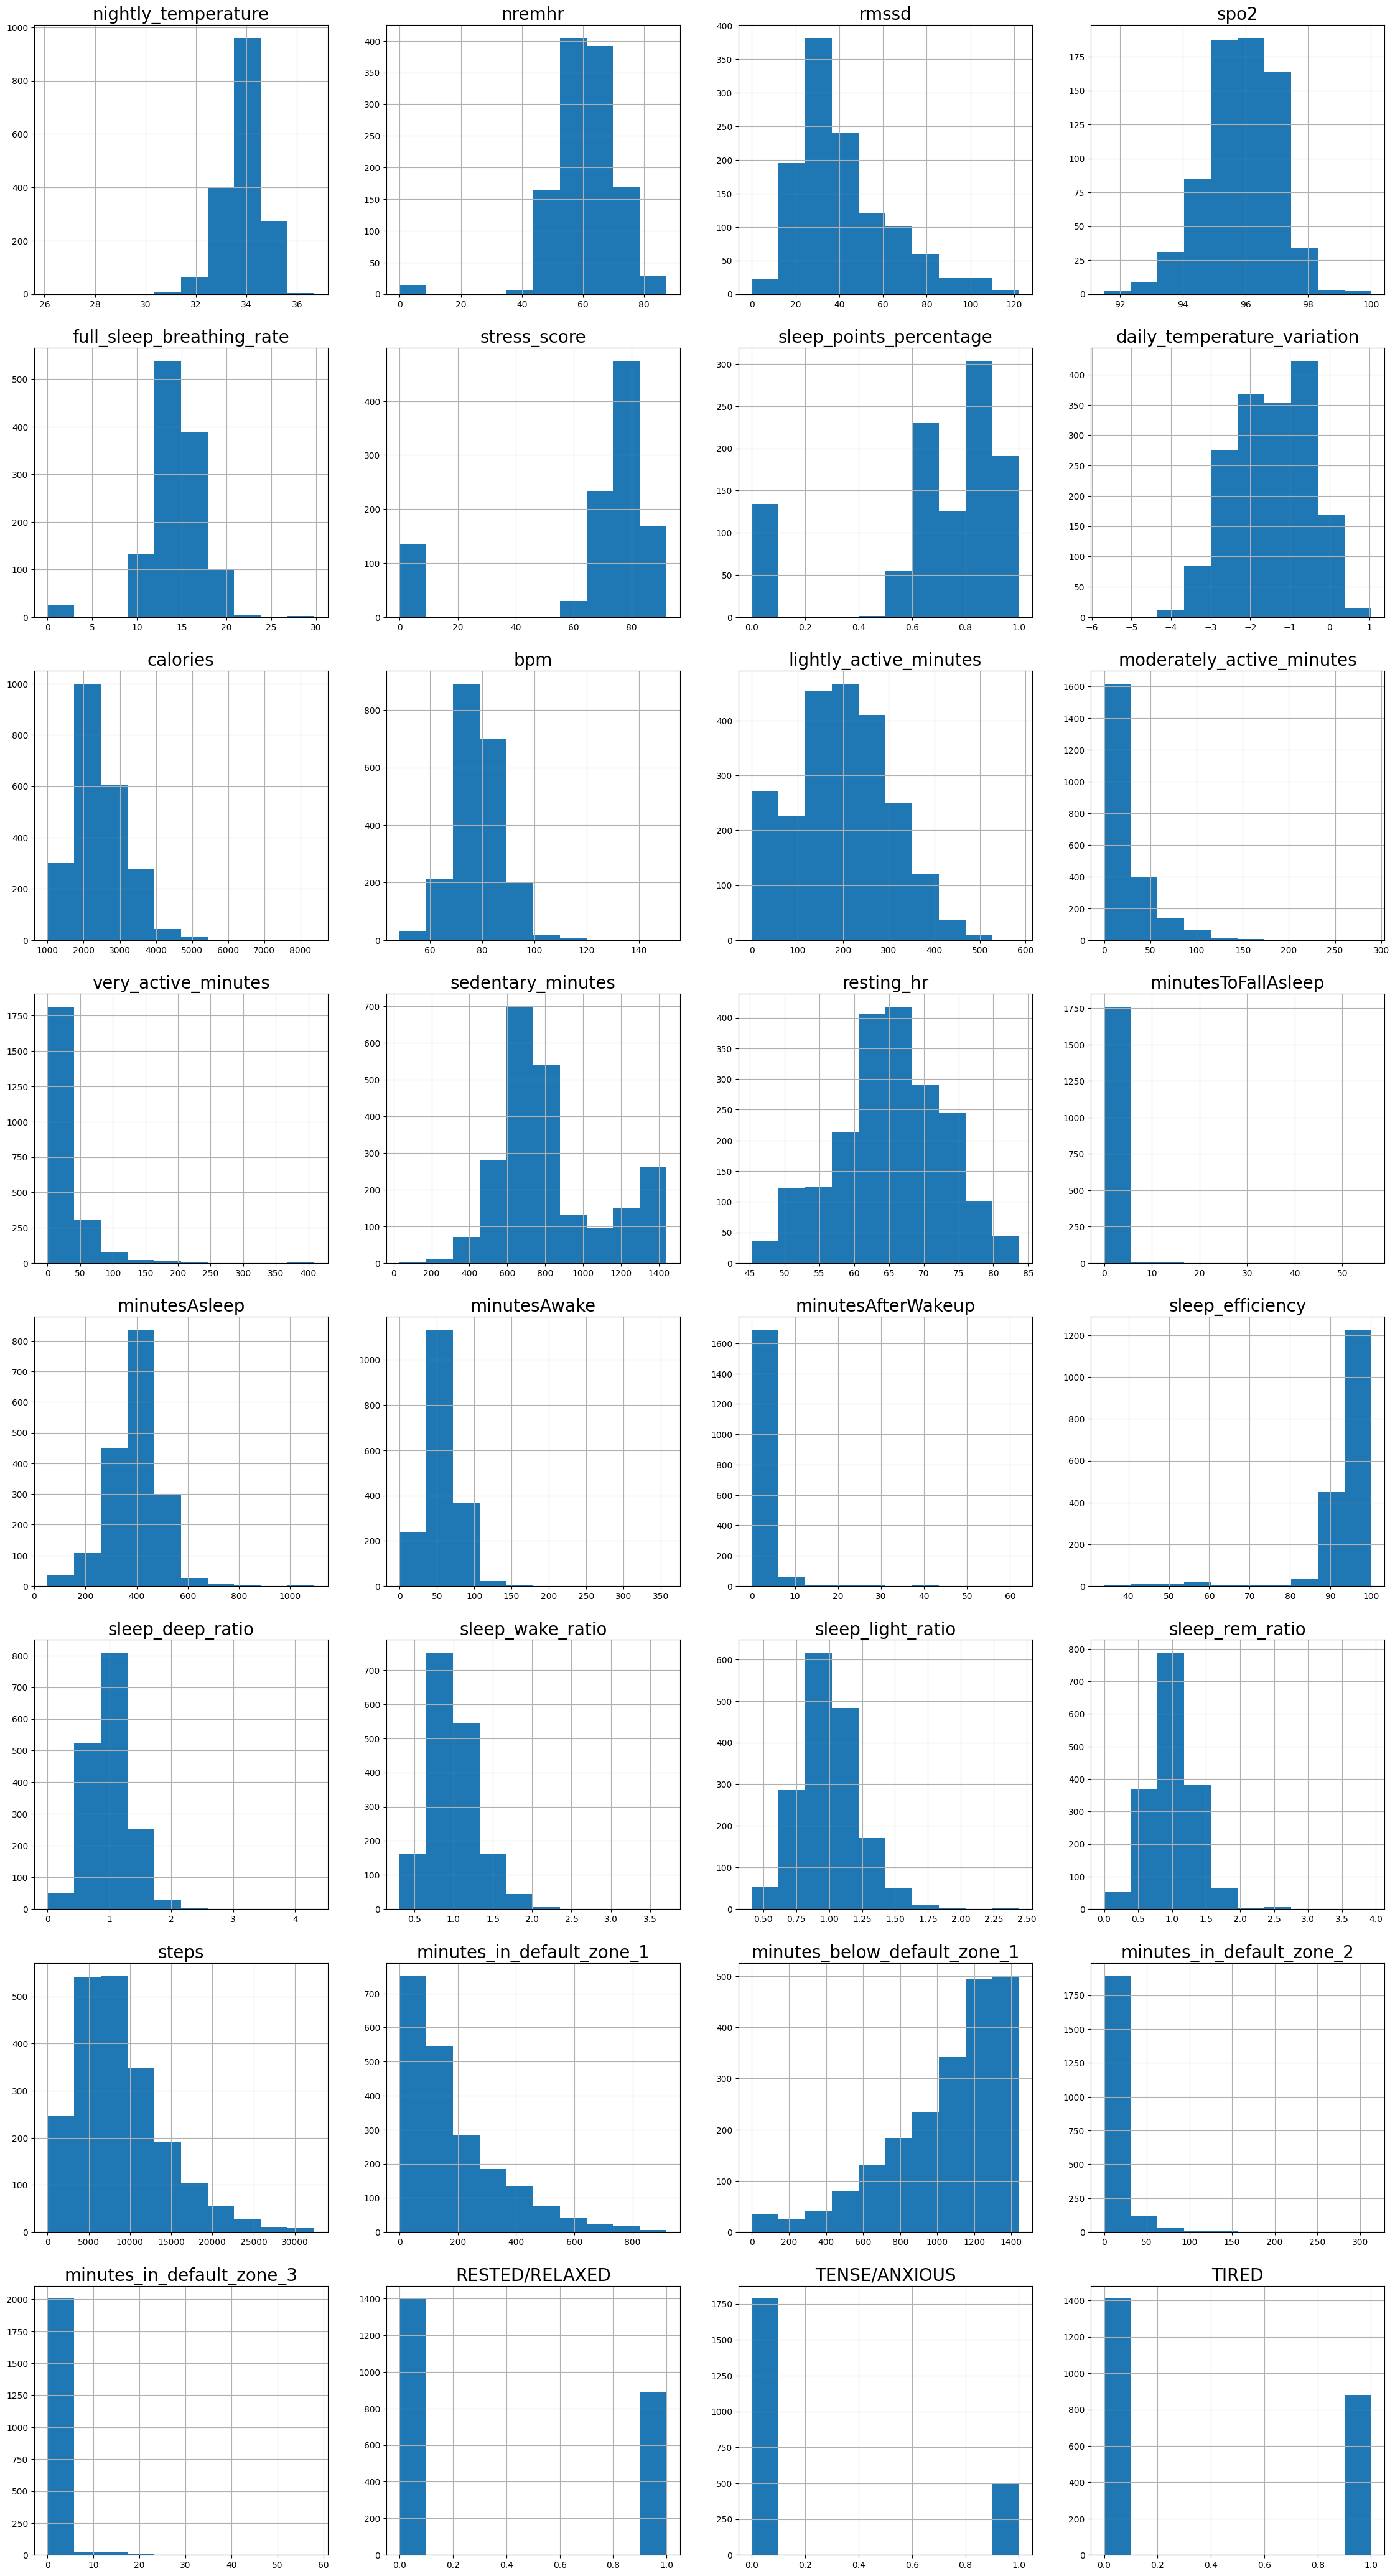

In [45]:
# Histogramas de les variables numèriques

plt.figure(figsize=(28,100))
plotnumber=1
for i in numeric_col:
    ax=plt.subplot(15,4,plotnumber)
    df[i].hist() 

    plt.title(i,size=20)
    plotnumber+=1
plt.show() 

#### Correlació

<Axes: >

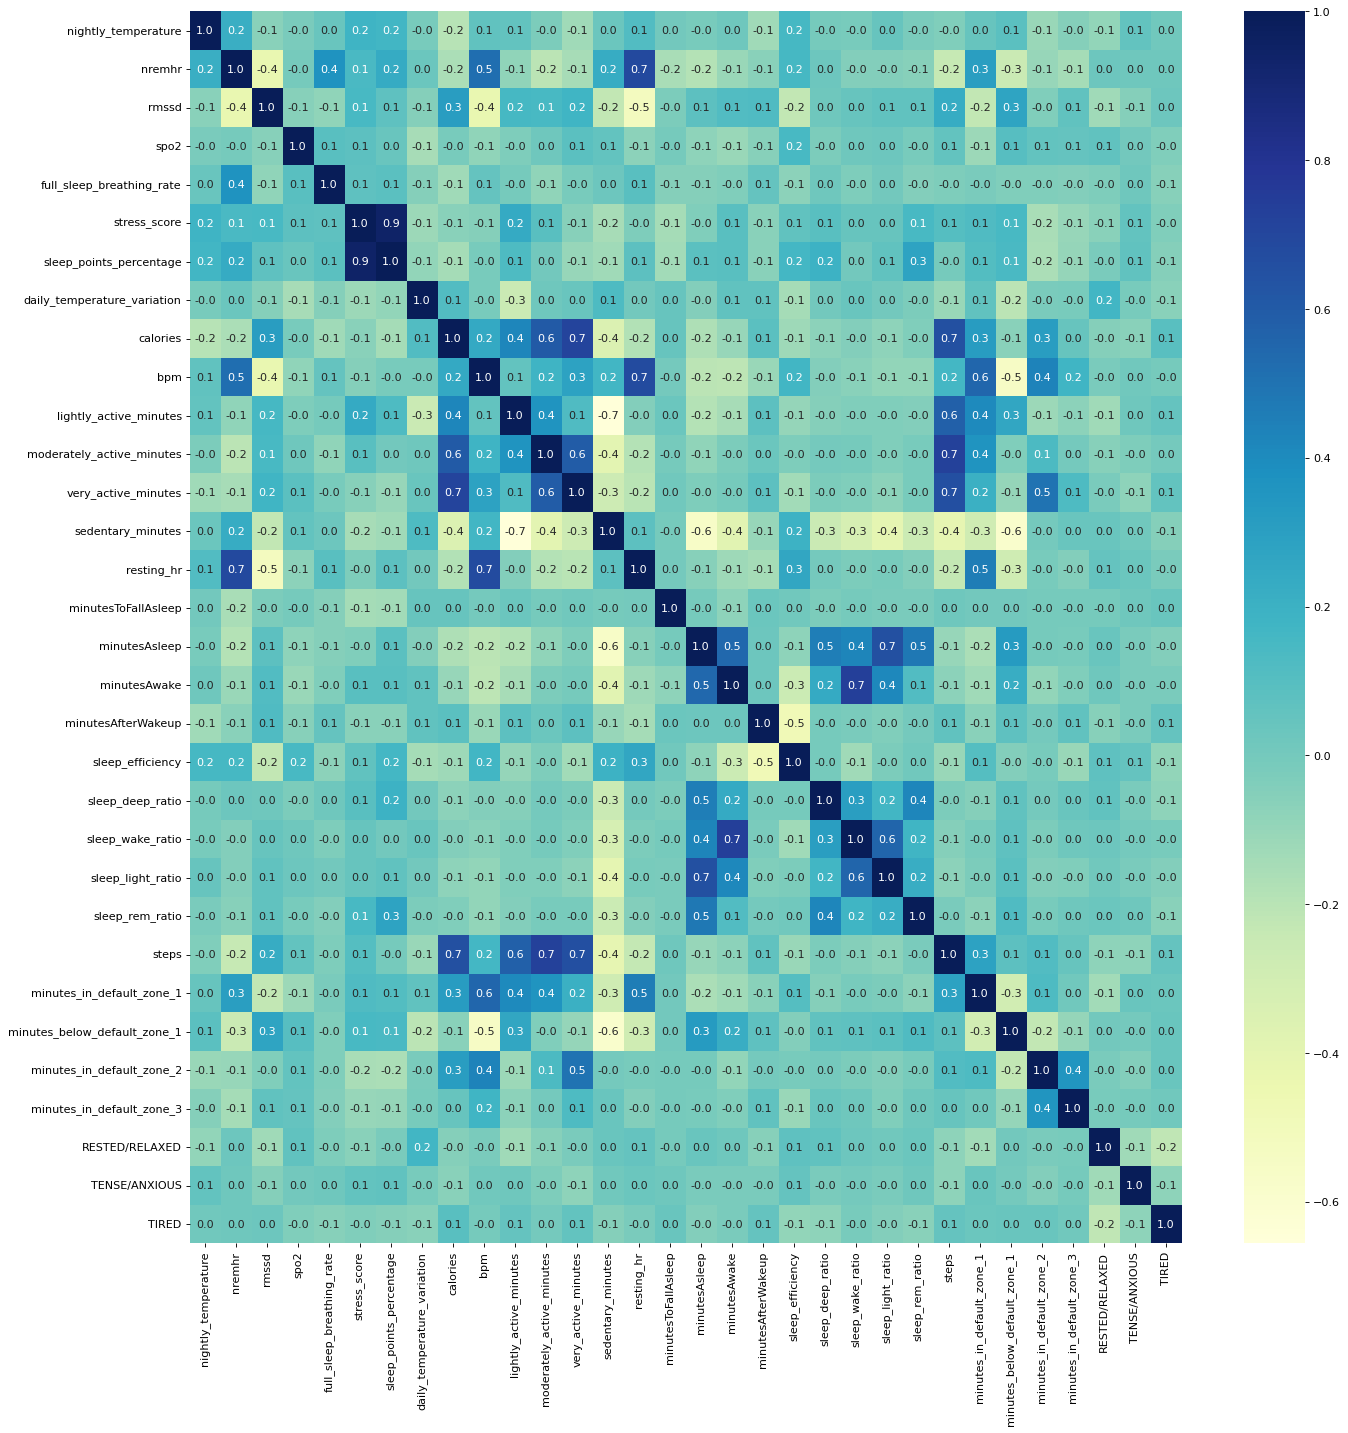

In [46]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(20, 20), dpi=80)
# plt.fig(figures)
sns.heatmap(corr, cmap="YlGnBu", annot=True,fmt='.1f')

## Preprocessament de dades

In [47]:
# Definim X, y
y = df['TENSE/ANXIOUS']
X = df.drop(columns=['TENSE/ANXIOUS'])

numeric_X = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categoric_X = X.select_dtypes(include=['category', 'object', 'bool']).columns.tolist()



In [ ]:
# Transformem les columnes amb pipeline

numeric_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")),
                        ("scaler", StandardScaler())])

categoric_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                            ("encoder", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer([
    ("num", numeric_pipe, numeric_X),
    ("cat", categoric_pipe, categoric_X)
])

display(preprocessor)



ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['nightly_temperature', 'nremhr', 'rmssd',
                                  'spo2', 'full_sleep_breathing_rate',
                                  'stress_score', 'sleep_points_percentage',
                                  'daily_temperature_variation', 'calories',
                                  'bpm', 'lightly_active_minutes',
                                  'moderately_active_minutes',
                                  'ver...
                                  'sleep_light_ratio', 'sleep_rem_ratio',
                                  'steps', 'minutes_in_default_zone_1',
                                  'minutes_below_default_zone_1',
                                  'minutes_in_default_zone_2',
                                  'minutes_in_default_zone_3', 'RESTED/RELAXED', ...]),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['date', 'mindfulness_session', 'age',
                                  'gender', 'bmi'])])

In [75]:
# Dividim el dataset en train i test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Comprovem com es visualitzaria el dataset despres del pipeline
# ––– numéricas
num_imputer   = SimpleImputer(strategy="median")
X_num_imp     = pd.DataFrame(
    num_imputer.fit_transform(X_train[numeric_X]),
    columns=numeric_X,
    index=X_train.index
)

# ––– categóricas
cat_imputer   = SimpleImputer(strategy="most_frequent")
X_cat_imp     = pd.DataFrame(
    cat_imputer.fit_transform(X_train[categoric_X]),
    columns=categoric_X,
    index=X_train.index
)

X_train_imp = pd.concat([X_num_imp, X_cat_imp], axis=1)
display(X_train_imp.head(20))

print(f'Files: {X_train_imp.shape[0]} \nColumnes: {X_train_imp.shape[1]} \n \n{X_train_imp.isnull().sum()/df.shape[0]*100}')


,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,daily_temperature_variation,calories,bpm,lightly_active_minutes,moderately_active_minutes,very_active_minutes,sedentary_minutes,resting_hr,minutesToFallAsleep,minutesAsleep,minutesAwake,minutesAfterWakeup,sleep_efficiency,sleep_deep_ratio,sleep_wake_ratio,sleep_light_ratio,sleep_rem_ratio,steps,minutes_in_default_zone_1,minutes_below_default_zone_1,minutes_in_default_zone_2,minutes_in_default_zone_3,RESTED/RELAXED,TIRED,date,mindfulness_session,age,gender,bmi
2224,33.971263,61.720,35.274,95.9,14.5,76.0,0.766667,-1.440833,2059.20,78.379465,0.0,0.0,0.0,1440.0,65.485315,0.0,400.0,55.0,0.0,95.0,0.986486,0.960784,0.985075,0.989796,7857.0,135.0,1132.5,1.0,0.0,0.0,1.0,2021-12-07,False,<30,MALE,>=30
6393,33.971263,61.720,35.274,95.9,14.5,76.0,0.766667,-1.440833,2337.42,78.379465,197.0,13.0,9.0,748.0,65.485315,0.0,400.0,55.0,0.0,95.0,0.986486,0.960784,0.985075,0.989796,7857.0,135.0,1132.5,1.0,0.0,0.0,0.0,2021-05-22,False,>=30,MALE,24.0
4696,33.971263,61.720,35.274,95.9,14.5,76.0,0.766667,-1.440833,1857.60,96.200000,0.0,0.0,0.0,1440.0,65.485315,0.0,400.0,55.0,0.0,95.0,0.986486,0.960784,0.985075,0.989796,7857.0,1.0,0.0,0.0,0.0,0.0,0.0,2021-12-27,False,>=30,MALE,25.0
4170,34.586418,61.720,35.274,95.9,14.5,76.0,0.766667,-3.131154,2226.23,78.633773,433.0,7.0,39.0,562.0,65.190772,0.0,370.0,29.0,0.0,95.0,0.905882,0.500000,0.844156,1.113636,14692.0,237.0,1194.0,9.0,0.0,1.0,1.0,2021-06-05,False,>=30,FEMALE,19.0
3316,33.669810,69.011,25.734,95.9,15.0,85.0,0.766667,-0.725702,3523.92,96.134354,342.0,17.0,66.0,805.0,77.577152,0.0,188.0,22.0,0.0,97.0,0.698630,0.448980,0.497436,0.493827,15762.0,786.0,630.0,23.0,0.0,0.0,0.0,2021-06-29,False,>=30,MALE,23.0
1283,34.320883,61.720,35.274,95.9,14.5,76.0,0.766667,-0.061673,3088.74,89.189283,226.0,33.0,41.0,823.0,69.563808,0.0,284.0,33.0,0.0,95.0,0.947368,0.733333,0.646018,0.865979,7690.0,208.0,1213.0,19.0,0.0,0.0,1.0,2021-07-14,False,>=30,MALE,22.0
6100,33.654443,58.456,56.876,95.9,13.0,76.0,0.766667,-0.520471,2109.03,69.005641,134.0,8.0,4.0,900.0,62.150351,0.0,323.0,71.0,0.0,90.0,1.106061,1.543478,1.297468,0.725806,4414.0,17.0,985.0,0.0,0.0,1.0,0.0,2021-07-09,False,<30,MALE,22.0
1391,34.021733,61.720,35.274,95.9,14.5,76.0,0.766667,-2.641725,2530.09,82.077188,279.0,3.0,12.0,536.0,73.720474,0.0,531.0,79.0,1.0,96.0,1.421053,1.385965,1.248996,0.875000,8930.0,125.0,1307.0,8.0,0.0,0.0,1.0,2021-11-30,False,<30,FEMALE,>=25
5641,34.704457,61.720,35.274,95.9,14.5,76.0,0.766667,-0.590808,2154.29,78.285606,211.0,3.0,20.0,847.0,65.325850,0.0,315.0,44.0,0.0,96.0,0.454545,0.771930,0.894068,0.958333,7330.0,193.0,1188.0,0.0,0.0,0.0,1.0,2021-05-26,False,>=30,FEMALE,24.0
1222,32.857309,61.629,26.094,96.8,14.0,75.0,0.666667,-2.607029,1622.50,80.206075,173.0,0.0,0.0,875.0,68.769298,0.0,334.0,58.0,0.0,94.0,1.111111,0.983051,0.792308,0.537037,4005.0,171.0,1052.0,46.0,14.0,0.0,1.0,2022-01-11,True,>=30,FEMALE,20.0


Files: 1832 
Columnes: 36 
 
nightly_temperature             0.0
nremhr                          0.0
rmssd                           0.0
spo2                            0.0
full_sleep_breathing_rate       0.0
stress_score                    0.0
sleep_points_percentage         0.0
daily_temperature_variation     0.0
calories                        0.0
bpm                             0.0
lightly_active_minutes          0.0
moderately_active_minutes       0.0
very_active_minutes             0.0
sedentary_minutes               0.0
resting_hr                      0.0
minutesToFallAsleep             0.0
minutesAsleep                   0.0
minutesAwake                    0.0
minutesAfterWakeup              0.0
sleep_efficiency                0.0
sleep_deep_ratio                0.0
sleep_wake_ratio                0.0
sleep_light_ratio               0.0
sleep_rem_ratio                 0.0
steps                           0.0
minutes_in_default_zone_1       0.0
minutes_below_default_zone_1    0.0

In [65]:
# Definim els models que provarem de utilitzar
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced', max_depth=None),
    "SVC": SVC(kernel="rbf", random_state=42, probability=True, class_weight='balanced')
}


resultats = {}

# Definim el cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for nom, model in models.items():
    # Creem el pipeline
    clf = ImbPipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("clf", model)
    ])

    # Avaluem el model amb cross-validation
    puntuacio = cross_val_score(clf, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)

    # Mostrem els resultats
    resultats[nom] = puntuacio.mean()
    print(f"{nom} | Mitjana Cross Validation ROC-AUC {puntuacio.mean():.3f} ± {puntuacio.std():.3f}")

Logistic Regression | Mitjana Cross Validation ROC-AUC 0.612 ± 0.022
Random Forest | Mitjana Cross Validation ROC-AUC 0.655 ± 0.021
SVC | Mitjana Cross Validation ROC-AUC 0.633 ± 0.010


Millor model: Random Forest


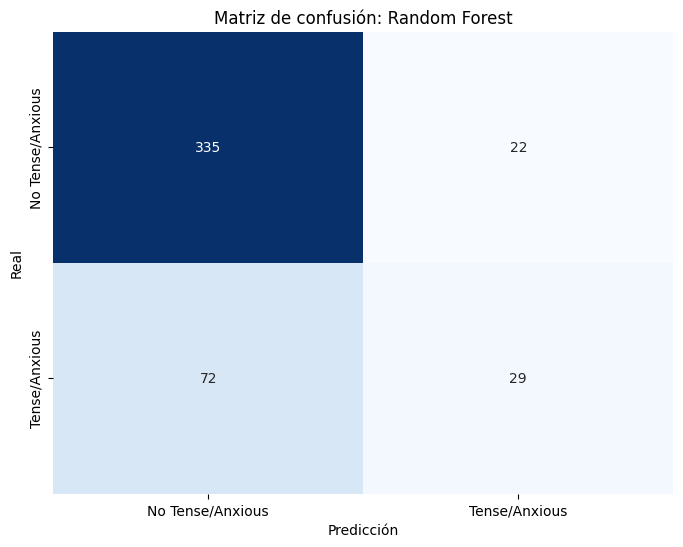


Classification report:
               precision    recall  f1-score   support

         0.0      0.823     0.938     0.877       357
         1.0      0.569     0.287     0.382       101

    accuracy                          0.795       458
   macro avg      0.696     0.613     0.629       458
weighted avg      0.767     0.795     0.768       458

Test ROC‑AUC: 0.722


In [57]:
# Escollim el millor resultat per avaluar el model

millor_model = max(resultats, key=resultats.get)
print(f"Millor model: {millor_model}")

millor_pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("clf", models[millor_model])
])

millor_pipeline.fit(X_train, y_train)

y_pred = millor_pipeline.predict(X_test)
y_proba = millor_pipeline.predict_proba(X_test)[:, 1]

matriu_confusio=confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(matriu_confusio, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['No Tense/Anxious', 'Tense/Anxious'], yticklabels=['No Tense/Anxious', 'Tense/Anxious'])
set_title= plt.title(f'Matriz de confusión: {millor_model}')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()


print("\nClassification report:\n", classification_report(y_test, y_pred, digits=3))
print(f"Test ROC‑AUC: {roc_auc_score(y_test, y_proba):.3f}")




